각 문서의 단어들을 어떤 방법으로 수치화했는지(DTM, Word2Vec 등),        
문서 간 단어들의 차이를 어떤 방법으로 계산했는지(유클리드 거리, 코사인 유사도 등)에 따라 문서의 유사도의 성능이 달라진다.

## 1. 코사인 유사도(Cosine Similarity)
### 1) 코사인 유사도
#### 두 벡터간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도.
두 벡터의 방향이 동일하면 1, 90도면 0, 180도(반대방향)이면 -1.       
__1에 가까울수록 유사도가 높다(-> 두 벡터가 가리키는 방향이 같다)__      
두 벡터 A,B의 코사인 유사도     
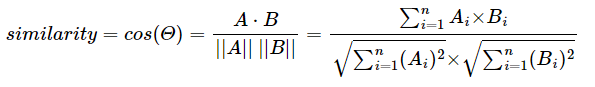

#### 예) DTM에 대해 코사인 유사도 구하기
          
문서1: 저는 사과 좋아요
문서2: 저는 바나나 좋아요
문서3: 저는 바나나 좋아요 저는 바나나 좋아요      
       
=> DTM             

|-|바나나|사과|저는|좋아요|
|---|---|---|---|---|
|문서1|0|1|1|1|
|문서2|1|0|1|1|
|문서3|2|0|2|2|

Numpy를 이용한 유사도 계산

In [1]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

# 코사인 유사도 계산하는 함수
def cos_sim(A,B):
    return dot(A,B)/(norm(A)*norm(B))

In [2]:
# 위의 세 문서에 대한 BoW
doc1=np.array([0,1,1,1])
doc2=np.array([1,0,1,1])
doc3=np.array([2,0,2,2])

In [4]:
print(cos_sim(doc1, doc2))
print(cos_sim(doc1, doc3))
print(cos_sim(doc2, doc3))

0.6666666666666667
0.6666666666666667
1.0000000000000002


문서3은 문서2에서 빈도수가 1씩 증가한 경우. => 코사인 유사도가 1이다.     
: 코사인 유사도는 문서 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있게 한다!

### 2) 유사도를 이용한 추천 시스템 구현하기

캐글의 영화 데이터셋을 이용한 영화 추천 시스템.     
TF-IDF와 코사인 유사도로 영화 줄거리에 기반하여 영화를 추천하는 추천 시스템을 만든다

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [6]:
data=pd.read_csv('movies_metadata.csv', low_memory=False)
data.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


데이터의 열들중 영화 제목인 title 열과 줄거리에 해당하는 overview 열을 이용해서, 좋아하는 영화를 입력하면 해당 영화의 줄거리와 유사한 영화를 찾아 추천하는 시스템을 만든다

In [7]:
# 총 데이터 중 20000개의 데이터만 사용
data=data.head(20000)

In [8]:
# 데이터의 overview 열에 null값이 있는지 확인 (null이 있으면 tf-idf가 계산되지 않음)
data['overview'].isnull().sum()

135

In [9]:
# null 값을 빈 값(empty value)로 대체
data['overview']=data['overview'].fillna("")

In [10]:
#tf-idf 수행
tfidf=TfidfVectorizer(stop_words='english')

tfidf_matrix=tfidf.fit_transform(data['overview'])
print(tfidf_matrix.shape)

(20000, 47487)


-> 20000개의 영화 설명에 47487개의 단어가 사용된 것!

In [11]:
# 코사인 유사도 구하기
cosine_sim=linear_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
# 영화 타이틀과 인덱스를 가진 테이블 만들기
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [13]:
idx=indices['Waiting to Exhale']
print(idx)

3


코사인 유사도를 이용하여 선택한 영화와 가장 overview가 유사한 10개의 영화를 찾는 함수 만들기

In [14]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 인덱스 가져오기
    idx = indices[title]
    
    # 모든 영화와 선택한 영화의 유사도 구하기
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 영화 정렬
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    
    # 가장 유사한 10개의 영화 받기
    sim_scores = sim_scores[1:11]
    
    # 가장 유사한 10개 영화의 인덱스 받아오기
    movie_indices = [i[0] for i in sim_scores]
    
    # 가장 유사한 10개 영화의 title 리턴
    return data['title'].iloc[movie_indices]

In [15]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

In [16]:
get_recommendations('Toy Story')

15348               Toy Story 3
2997                Toy Story 2
10301    The 40 Year Old Virgin
8327                  The Champ
1071      Rebel Without a Cause
11399    For Your Consideration
1932                  Condorman
3057            Man on the Moon
485                      Malice
11606              Factory Girl
Name: title, dtype: object

## 2. 여러가지 유사도 기법

### 1) 유클리드 거리(Euclidean distance)
두 점 사이의 거리 구하기
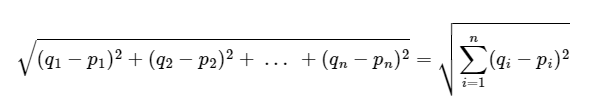
예)             

|-|바나나|사과|저는|좋아요|
|---|---|---|---|---|
|문서1|0|1|1|1|
|문서2|1|0|1|1|
|문서3|2|0|2|2|
         
=> 4차원 공간(단어 4개)에 문서1, 문서2, 문서3을 배치해서 거리를 구하는 것!        
다음 문서Q와 문서1,2,3의 거리 각각 구해보기         

|-|바나나|사과|저는|좋아요|
|---|---|---|---|---|
|문서Q|1|1|0|1|

In [17]:
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

doc1 = np.array((2,3,0,1))
doc2 = np.array((1,2,3,1))
doc3 = np.array((2,1,2,2))
docQ = np.array((1,1,0,1))

print(dist(doc1, docQ))
print(dist(doc2, docQ))
print(dist(doc3, docQ))

2.23606797749979
3.1622776601683795
2.449489742783178


=> 문서 1이 문서 Q와 가장 유사하다!! (값이 작다 => 문서간 거리가 가장 가깝다)

### 2) 자카드 유사도(Jaccard similarity)
합집합에서 교집합의 비율 구하기! -> 교집합 크기를 합집합 크기로 나눈 값.     
두 집합이 동일하면 1을 가지고, 두 집합의 공통 원소가 없으면 0을 가진다.
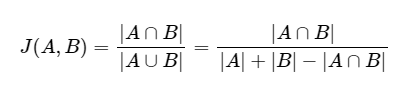


In [18]:
# 두 문서 모두 등장한 단어: apple, banana
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana coupon passport love you"

# 토큰화
tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

# 토큰화 결과 출력
print(tokenized_doc1)
print(tokenized_doc2)

['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
['apple', 'banana', 'coupon', 'passport', 'love', 'you']


In [19]:
# 합집합 구하기
union = set(tokenized_doc1).union(set(tokenized_doc2))
print(union)

{'passport', 'banana', 'watch', 'you', 'love', 'card', 'everyone', 'like', 'coupon', 'holder', 'apple', 'likey'}


In [20]:
# 교집합 구하기
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print(intersection)

{'banana', 'apple'}


In [21]:
# 자카드 유사도: 교집합 수를 합집합 수로 나누기!
print(len(intersection)/len(union))

0.16666666666666666


=> 자카드 유사도! 두 문서에서 공통적으로 등장한 단어의 비율이라고도 볼 수 있다